In [1]:
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D,Conv2DTranspose
from tensorflow.keras import metrics
from tensorflow.keras import backend as K

In [2]:
from PIL import Image

# Carga de datos

Train luego será aumentado

In [3]:
train_path = Path("PhC-C2DH-U373/01/").glob("**/*tif")
val_path = Path("PhC-C2DH-U373/02/").glob("**/*tif")

In [4]:
train_images = list()
train_masks = list()
for file in train_path:
    train_images.append(np.array(Image.open(file)).reshape(1,520,696))
    train_masks.append(np.array(Image.open(f'PhC-C2DH-U373/01_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

val_images = list()
val_masks = list()

for file in val_path:
    val_images.append(np.array(Image.open(file)).reshape(1,520,696))
    val_masks.append(np.array(Image.open(f'PhC-C2DH-U373/02_ST/SEG/man_seg{file.name[1:]}')).reshape(1,520,696))

Normalización de los datos

In [5]:
train_images = np.vstack(train_images)/255
train_masks = 1*(np.vstack(train_masks) > 0)

val_images = np.vstack(val_images)/255
val_masks = 1*(np.vstack(val_masks) >0 )

# Visualización de algunos datos

Esta función muestra la imagen de fondo y las máscaras transparentes, una en verde para el ground truth y otra blanca para la prediccion

In [6]:
# Funcion para mostrar las imagenes con las mascaras superpuestas
def showMaskedImage(img, mask1=None, mask2=None, maskAlpha=0.3):
  plt.imshow(img, vmin=0, vmax=1, cmap="gray")
  if mask1 is not None:
    plt.imshow(mask1, vmin=0, vmax=1, cmap="Greens", alpha=mask1*maskAlpha)
  if mask2 is not None:
    plt.imshow(mask2, vmin=0, vmax=1, cmap="gray", alpha=mask2*maskAlpha)

  plt.xticks([])
  plt.yticks([])
  plt.grid(False)

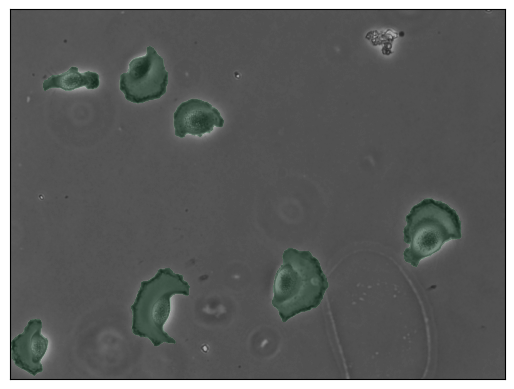

In [7]:
idx = 100
showMaskedImage(train_images[idx], train_masks[idx])
plt.show()

# Armo datasets de tensorflow y aumento

Para mantener sincronizada la aumentación entre la imagen y la máscara, armo una entrada de 4 canales que se descompondrán durante el entrenamiento.

In [8]:
x_train = np.stack((train_images, train_masks), axis=-1)
x_val = np.stack((val_images, val_masks), axis=-1)

In [9]:
x_train[:,:,:,0].max()

0.7294117647058823

Los x son un arreglo de matrices donde cada elemento es un arreglo con el valor del pixel de la imagen ([x,y,z,0]) y el valor de la mascara en ese pixel ([x,y,z,1])

In [10]:
x_train.shape

(115, 520, 696, 2)

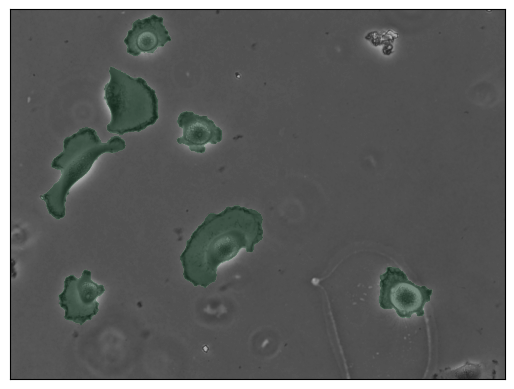

In [11]:
showMaskedImage(x_train[0,:,:,0], x_train[0,:,:,1])
plt.show()

# Red básica fully convolutional con Atrous Convolutions

El objetivo es armar una red sencilla para ver el comportamiento del dataset. Se utilizan las Atrous Convolution (dilated convolutions) para aumentar el campo perceptual con menor cantidad de capas.

Todas capas convolucionales con padding same, cantidad de filtros y tamaño de kernel fijo. El input shape no esta fijo, ya que puede ser cualquier tamaño arbitrario porque la red es solo convolucional

In [12]:
filters = 16
kernel_size = 10
def get_red_seg():
    return Sequential([
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1, input_shape = (None,None,1)),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 2),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 4),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 8),
        tf.keras.layers.Conv2D(filters, kernel_size,padding="same", activation = "relu", dilation_rate = 1),
        tf.keras.layers.Conv2D(1, kernel_size,padding="same", activation = "sigmoid", dilation_rate = 1)
    ])


# Redes de preprocesamiento

Se utilizarán dentro del modelo, una para el entrenamiento, donde podemos hacer cortes, zoom y traslaciones aleatorias, para validación solo hacemos un corte en el centro

In [13]:
def get_preproc():
    return Sequential([
        tf.keras.layers.RandomCrop(512,512),
        tf.keras.layers.RandomFlip(mode='horizontal_and_vertical'),
        #tf.keras.layers.RandomZoom((-0.1,0.3)),
        #tf.keras.layers.RandomTranslation((-0.5, 0.5), (-0.5,0.5)),
        #tf.keras.layers.RandomRotation((0,1)),
        #tf.keras.layers.RandomZoom((0.5,0.5)),
        ])

def get_preproc_val():
    return Sequential([
        tf.keras.layers.CenterCrop(512,512),
        ])

Como el preprocesamiento es random, lo llamamos varias veces con la misma imagen y los resultados son distintos. Se puede ver que la mascara se modifica de la misma forma que la imagen

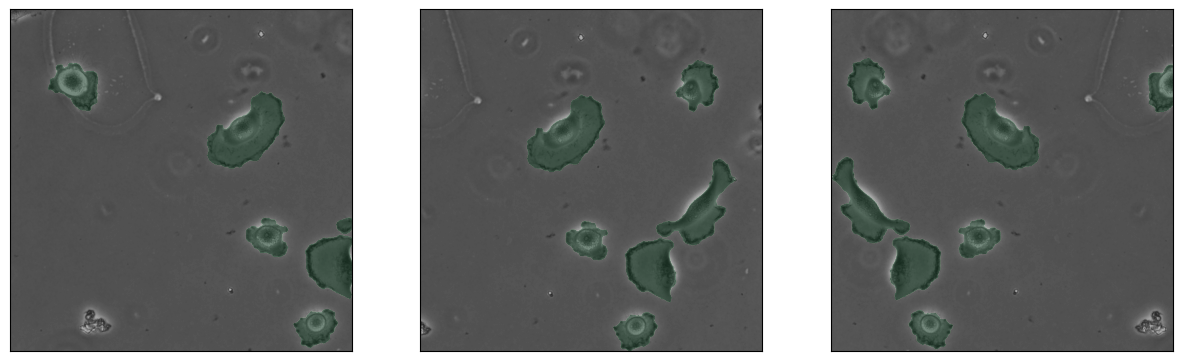

In [14]:
preproc = get_preproc()
aux_elem = preproc(x_train[0])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
showMaskedImage(aux_elem[:,:,0], aux_elem[:,:,1])

aux_elem = preproc(x_train[0])
plt.subplot(1,3,2)
showMaskedImage(aux_elem[:,:,0], aux_elem[:,:,1])
plt.subplot(1,3,3)

aux_elem = preproc(x_train[0])
showMaskedImage(aux_elem[:,:,0], aux_elem[:,:,1])
plt.show()

Funciones para obtener métricas de dice y también para usarlo de loss

In [15]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Modelo de segmentación base

Se utiliza una clase para reunir los dos modelos de preprocesamiento con el modelo de segmentación para poder realizar el entrenamiento. Una vez entrenado, el modelo de segmentación se puede separar y usarlo independientemente.

Se modifica un poco esta clase según el ejemplo en https://keras.io/guides/customizing_what_happens_in_fit/ para poder reportar las métricas durante el entrenamiento y elegir la loss y métricas a gusto en la compilación

In [16]:
class SegmentationModel(Model):
    def __init__(self, red_preproc, red_segmentacion, red_preproc_val):
        super().__init__()
        self.red_segmentacion = red_segmentacion
        self.red_preproc = red_preproc
        self.red_preproc_val = red_preproc_val
        self.loss_tracker = metrics.Mean(name="loss")
        self.dice_metric = metrics.Mean(name="dice")    # Se agrega el dice como métrica
        self.dice = False

    def call(self, inputs, training=False):
      return self.red_segmentacion(inputs[:,:,:1])

    def train_step(self, data):

        # Preprocesamos la data y separamos imagen y mascara
        data_aug = self.red_preproc(data)

        imgIn = data_aug[:,:,:,:1]      # La imagen de entrada (shape: (H, W, 1))
        maskIn = data_aug[:,:,:,1:2]    # La mascara correcta

        # Aca hacemos la prediccion y calculamos la loss, dentro de este contexto se registran los cambios
        with tf.GradientTape() as tape:
          # Hacemos la prediccion de la entrada
          mask_out = self.red_segmentacion(imgIn, training=True)
          # Compute the loss value
          # (the loss function is configured in `compile()`)
          # loss = self.compute_loss(maskIn, mask_out)   # Asi puedo usar cualquier loss generica definida en compile()

          # Aca podemos decidir si usar BCE o Dice para la loss
          if self.dice:
            loss = dice_loss(maskIn, mask_out)
          else:
            loss = tf.keras.losses.binary_crossentropy(maskIn, mask_out)

        # Compute gradients
        trainable_vars = self.red_segmentacion.trainable_variables    # Los pesos
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.dice_metric.update_state(dice_coef(maskIn, mask_out))


        # # Update metrics (includes the metric that tracks the loss)
        # for metric in self.metrics:
        #     if metric.name == "loss":
        #        continue
        #         # metric.update_state(loss)
        #     else:
        #         metric.update_state(maskIn, mask_out)

        # Return a dict mapping metric names to current value

        # return {m.name: m.result() for m in self.metrics}
        return {"loss": self.loss_tracker.result(), "dice": self.dice_metric.result()}

    def test_step(self, data):

      # Preprocesamos la data y separamos imagen y mascara
      data_preproc = self.red_preproc_val(data)

      imgIn = data_preproc[:,:,:,:1]      # La imagen de entrada (shape: (H, W, 1))
      maskIn = data_preproc[:,:,:,1:2]    # La mascara correcta

      mask_out = self.red_segmentacion(imgIn)

      # loss = self.compute_loss(maskIn, mask_out)

      # Aca podemos decidir si usar BCE o Dice para la loss
      if self.dice:
        loss = dice_loss(maskIn, mask_out)
      else:
        loss = tf.keras.losses.binary_crossentropy(maskIn, mask_out)

      self.loss_tracker.update_state(loss)
      self.dice_metric.update_state(dice_coef(maskIn, mask_out))

      # # Update the metrics.
      # for metric in self.metrics:
      #     if metric.name != "loss":
      #         metric.update_state(maskIn, mask_out)

      # Return a dict mapping metric names to current value.
      # Note that it will include the loss (tracked in self.metrics).
      # return {m.name: m.result() for m in self.metrics}
      return {"loss": self.loss_tracker.result(), "dice": self.dice_metric.result()}

    # Esto es necesario para resetear las metricas entre epochs
    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [self.loss_tracker, self.dice_metric]

## Probando modelos

### Modelo Atrous con loss BCE

In [19]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa = get_red_seg()
model = SegmentationModel(preproc, red_falopa, preproc_val)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [21]:
# model.summary()
red_falopa.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 16)    1616      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 16)    25616     
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 105,681
Trainable params: 105,681
Non-tr

In [22]:
len(x_val)/(len(x_train)+len(x_val))

0.5

In [24]:
model.fit(np.vstack([x_train, x_val]), batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 74s 2s/step - loss: 0.6584 - dice: 0.1521 - val_loss: 0.5635 - val_dice: 0.0655
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.4906 - dice: 0.1360 - val_loss: 0.2313 - val_dice: 0.0572
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.3650 - dice: 0.0632 - val_loss: 0.1769 - val_dice: 0.0486
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.3421 - dice: 0.0748 - val_loss: 0.2281 - val_dice: 0.0569
Epoch 5/100
8/8 [==============================] - 8s 1s/step - loss: 0.3343 - dice: 0.0867 - val_loss: 0.1973 - val_dice: 0.0535
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.3406 - dice: 0.0762 - val_loss: 0.2002 - val_dice: 0.0533
Epoch 7/100
8/8 [==============================] - 8s 1s/step - loss: 0.3346 - dice: 0.0871 - val_loss: 0.2003 - val_dice: 0.0535
Epoch 8/100
8/8 [==============================] - 8s 1s/step - loss: 0.3265 - dice: 0.08

Veamos como resultan algunas predicciones

In [55]:
pred = red_falopa(x_val[0:3,:,:,:1])
pred.shape

TensorShape([3, 520, 696, 1])

In [56]:
pred.numpy().max()

0.99989295

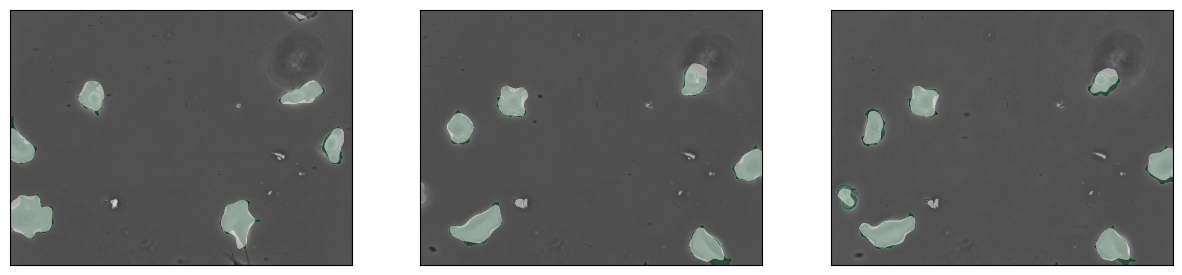

In [58]:
plt.figure(figsize=(15,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  showMaskedImage(x_val[i,:,:,0], x_val[i,:,:,1], pred.numpy()[i][...,0] > 0.5, maskAlpha=0.5)

plt.show()

Calculamos el dice en validacion, sin ningun tipo de preprocesamiento (Solo para 20 valores poque no alcanza la GPU)

In [84]:
y_true = x_val[:20,:,:,1:2].astype('float32')
y_pred = red_falopa(x_val[:20,:,:,0:1])
print(dice_coef(y_true, y_pred).numpy())

0.7863913


Dio incluso mejor que con preprocesamiento

### Modelo Atrous con loss Dice

Volvemos a copiar el modelo, pero con el parametro de dice=True

In [19]:
preproc= get_preproc()
preproc_val = get_preproc_val()
red_falopa2 = get_red_seg()
model2 = SegmentationModel(preproc, red_falopa2, preproc_val)
model2.dice = True

In [20]:
model2.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

In [21]:
model2.fit(np.vstack([x_train, x_val]), batch_size=16, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
8/8 [==============================] - 68s 2s/step - loss: 0.8477 - dice: 0.1523 - val_loss: 0.9330 - val_dice: 0.0670
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.8345 - dice: 0.1655 - val_loss: 0.9314 - val_dice: 0.0686
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.8358 - dice: 0.1642 - val_loss: 0.9315 - val_dice: 0.0685
Epoch 4/100
8/8 [==============================] - 8s 1s/step - loss: 0.8300 - dice: 0.1700 - val_loss: 0.9314 - val_dice: 0.0686
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.8312 - dice: 0.1688 - val_loss: 0.9315 - val_dice: 0.0685
Epoch 6/100
8/8 [==============================] - 8s 1s/step - loss: 0.8289 - dice: 0.1711 - val_loss: 0.9313 - val_dice: 0.0687
Epoch 7/100
8/8 [==============================] - 9s 1s/step - loss: 0.8196 - dice: 0.1804 - val_loss: 0.9277 - val_dice: 0.0723
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 0.8092 - dice: 0.19

En este caso no tuvimos problemas de estabilidad y pudimos entrenar perfectamente con dice como loss. Incluso se puede ver que la métrica mejoró bastante utilizando esta función, y que además entrenó mucho mas rápido

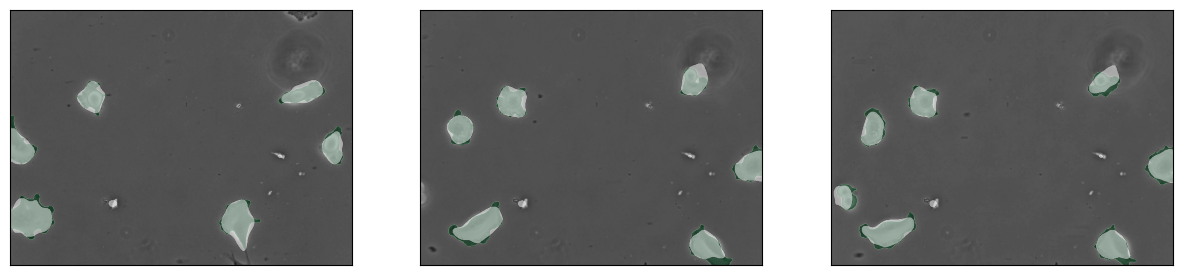

In [22]:
pred = red_falopa2(x_val[0:3,:,:,:1])

plt.figure(figsize=(15,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  showMaskedImage(x_val[i,:,:,0], x_val[i,:,:,1], pred.numpy()[i][...,0] > 0.5, maskAlpha=0.5)

plt.show()

In [24]:
y_true = x_val[:20,:,:,1:2].astype('float32')
y_pred = red_falopa2(x_val[:20,:,:,0:1])
print(dice_coef(y_true, y_pred).numpy())

0.81608933


### Modelo UNet

La implementación dada de UNet realiza el armado de las capas de forma recursiva, como se explica en los comentarios

In [17]:
img_shape = (512, 512, 1)

# Bloque convolucional de la UNet, con posibilidad de agregar batch normalization y/o dropout
	# m: Input
	# dim: Cantidad de filtros
	# acti: Función de activacion de las capas convolucionales
	# bn: Batch Normalization (True / False)
	# res: Conexion residual entre la entrada y la salida (True / False)
	# do: Dropout rate
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

# Funcion recursiva que implementa las capas de la UNet
	# m: Input
	# dim: Cantidad de filtros
	# depth: Cantidad de niveles
	# inc: tasa de incremento en la cantidad de filtros
	# acti, do, bn, res: Parametros del conv_block
	# mp: Decide si hacer Max pooling (True) o convolucion con stride 2 al bajar de nivel
	# up: Decide si hacer el Upsampling clasico (True) o con Transposed convolution (False) al subir de nivel
def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)		# Crea recursivamente la jerarquía de niveles
																						# Primero se crean los nivles hacia abajo con el bloque convolucional y max pooling hasta el nivel 0
																						# Luego se crea los niveles equivalentes hacia arriba con UpSampling o Transpose
																						# Y se le agrega la concatenacion con la capa del mismo nivel que bajaba
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])							# Skip connection entre capas del mismo nivel de la UNet
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)		# Bloque de la capa 0
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)		# Sigmoidea al final para interpretar el resultado como probabilidad
	return Model(inputs=i, outputs=o)

### Modelo UNet con loss BCE

In [18]:
preproc_unet = get_preproc()
preproc_unet_val = get_preproc_val()
red_unet = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet = SegmentationModel(preproc_unet, red_unet, preproc_unet_val)

In [19]:
model_unet.compile(optimizer = tf.keras.optimizers.Adam(1e-4))

Bajamos el batch size porque la GPU no nos daba para tanto

In [20]:
model_unet.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
15/15 [==============================] - 48s 1s/step - loss: 0.6475 - dice: 0.1478 - val_loss: 0.4974 - val_dice: 0.0611
Epoch 2/100
15/15 [==============================] - 11s 772ms/step - loss: 0.4039 - dice: 0.0767 - val_loss: 0.2790 - val_dice: 0.0495
Epoch 3/100
15/15 [==============================] - 11s 774ms/step - loss: 0.3619 - dice: 0.0755 - val_loss: 0.2312 - val_dice: 0.0454
Epoch 4/100
15/15 [==============================] - 12s 781ms/step - loss: 0.3455 - dice: 0.0745 - val_loss: 0.2071 - val_dice: 0.0437
Epoch 5/100
15/15 [==============================] - 12s 785ms/step - loss: 0.3328 - dice: 0.0802 - val_loss: 0.1914 - val_dice: 0.0467
Epoch 6/100
15/15 [==============================] - 12s 785ms/step - loss: 0.2861 - dice: 0.1180 - val_loss: 0.1252 - val_dice: 0.0906
Epoch 7/100
15/15 [==============================] - 12s 787ms/step - loss: 0.2082 - dice: 0.2493 - val_loss: 0.0934 - val_dice: 0.2490
Epoch 8/100
15/15 [==============================] 

Se puede ver que tiene una performance mucho mejor que el modelo anterior

In [21]:
red_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

Ahora siempre tenemos que hacer el preprocesamiento porque tenemos un tamaño de entrada fijo para evitar problemas con tamaños impares al hacer upsampling

In [22]:
aux = preproc_unet_val(x_val[0:3,:,:,:])
pred = red_unet(aux[:,:,:,0])
pred.shape

TensorShape([3, 512, 512, 1])

In [23]:
pred.numpy().max()

0.99999356

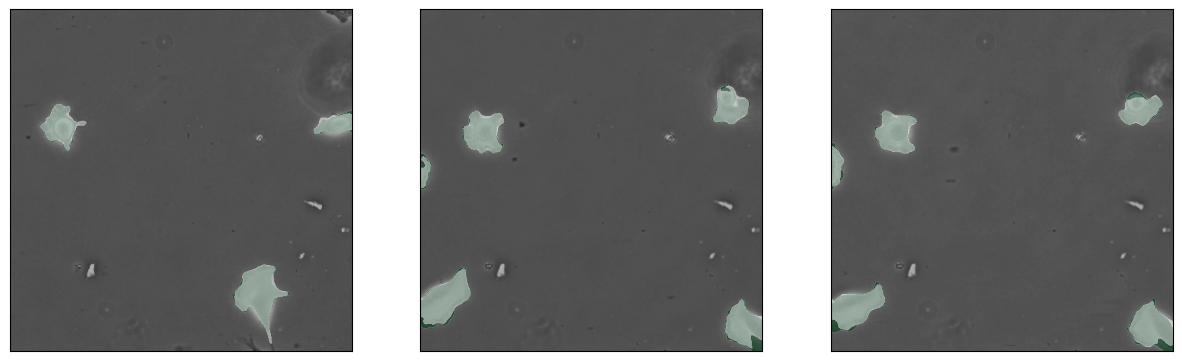

In [24]:
plt.figure(figsize=(15,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  showMaskedImage(aux[i,:,:,0], aux[i,:,:,1], pred.numpy()[i][...,0] > 0.5, maskAlpha=0.5)

plt.show()

In [32]:
model_unet.evaluate(x_val, batch_size=8)

15/15 [==============================] - 3s 180ms/step - loss: 0.0173 - dice: 0.9069


[0.01726205088198185, 0.9069045186042786]

### Modelo UNet con loss Dice

In [29]:
preproc_unet = get_preproc()
preproc_unet_val = get_preproc_val()
red_unet2 = UNet(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet2 = SegmentationModel(preproc_unet, red_unet2, preproc_unet_val)
model_unet2.dice = True

In [30]:
model_unet2.compile(optimizer = tf.keras.optimizers.Adam(1e-4))

In [31]:
model_unet2.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
15/15 [==============================] - 22s 873ms/step - loss: 0.8418 - dice: 0.1582 - val_loss: 0.9315 - val_dice: 0.0685
Epoch 2/100
15/15 [==============================] - 11s 766ms/step - loss: 0.8314 - dice: 0.1686 - val_loss: 0.9294 - val_dice: 0.0706
Epoch 3/100
15/15 [==============================] - 11s 765ms/step - loss: 0.8246 - dice: 0.1754 - val_loss: 0.9270 - val_dice: 0.0730
Epoch 4/100
15/15 [==============================] - 11s 775ms/step - loss: 0.8179 - dice: 0.1821 - val_loss: 0.9184 - val_dice: 0.0816
Epoch 5/100
15/15 [==============================] - 12s 786ms/step - loss: 0.7754 - dice: 0.2246 - val_loss: 0.8886 - val_dice: 0.1114
Epoch 6/100
15/15 [==============================] - 12s 788ms/step - loss: 0.7235 - dice: 0.2765 - val_loss: 0.8595 - val_dice: 0.1405
Epoch 7/100
15/15 [==============================] - 12s 778ms/step - loss: 0.4632 - dice: 0.5368 - val_loss: 0.4002 - val_dice: 0.5998
Epoch 8/100
15/15 [=============================

Nuevamente se observa que entrena más rápico con esta función de loss, aunque en este caso no se nota una mejora en la metrica de validacion final

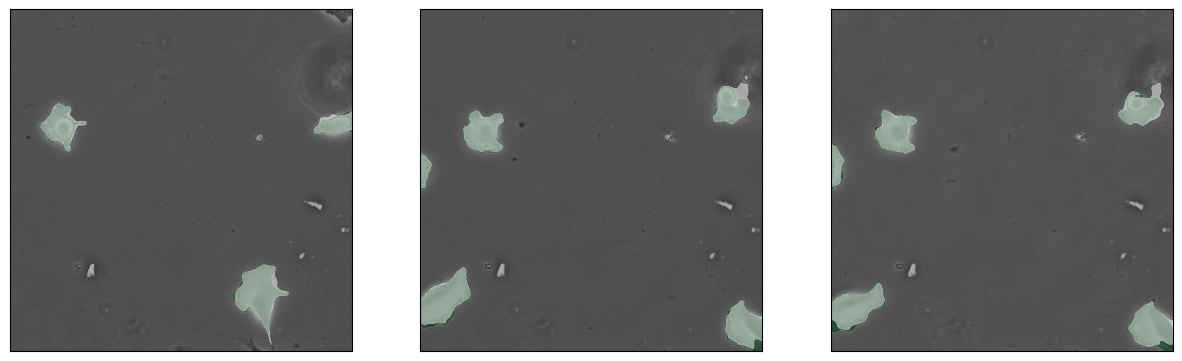

In [33]:
aux = preproc_unet_val(x_val[0:3,:,:,:])
pred = red_unet2(aux[:,:,:,0])

plt.figure(figsize=(15,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  showMaskedImage(aux[i,:,:,0], aux[i,:,:,1], pred.numpy()[i][...,0] > 0.5, maskAlpha=0.5)

plt.show()

In [34]:
model_unet2.evaluate(x_val, batch_size=8)

15/15 [==============================] - 3s 180ms/step - loss: 0.1005 - dice: 0.8995


[0.10054334253072739, 0.8994566798210144]

### UNet con Mirror Padding

Ahora cambiamos la implementacion de la red para agregar mirror padding

In [17]:
img_shape = (512, 512, 1)

# Bloque convolucional de la UNet, con posibilidad de agregar batch normalization y/o dropout
	# m: Input
	# dim: Cantidad de filtros
	# acti: Función de activacion de las capas convolucionales
	# bn: Batch Normalization (True / False)
	# res: Conexion residual entre la entrada y la salida (True / False)
	# do: Dropout rate
def conv_block_mirror(m, dim, acti, bn, res, do=0):
  n = tf.pad(m, tf.constant([[0,0], [0,2], [0,2], [0, 0]]), mode='reflect')       # Se hace el mirror padding, espejando los dos ultimos elemetos en cada eje
  n = Conv2D(dim, 3, activation=acti, padding='valid')(n)                         # Con padding valid
  n = BatchNormalization()(n) if bn else n
  n = Dropout(do)(n) if do else n
  n = tf.pad(n, tf.constant([[0,0], [0,2], [0,2], [0, 0]]), mode='reflect')
  n = Conv2D(dim, 3, activation=acti, padding='valid')(n)
  n = BatchNormalization()(n) if bn else n
  return Concatenate()([m, n]) if res else n

# Funcion recursiva que implementa las capas de la UNet
	# m: Input
	# dim: Cantidad de filtros
	# depth: Cantidad de niveles
	# inc: tasa de incremento en la cantidad de filtros
	# acti, do, bn, res: Parametros del conv_block
	# mp: Decide si hacer Max pooling (True) o convolucion con stride 2 al bajar de nivel
	# up: Decide si hacer el Upsampling clasico (True) o con Transposed convolution (False) al subir de nivel
def level_block_mirror(m, dim, depth, inc, acti, do, bn, mp, up, res):
  if depth > 0:
    n = conv_block_mirror(m, dim, acti, bn, res)
    m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='valid')(tf.pad(n, tf.constant([[0,0], [0,2], [0,2], [0, 0]]), mode='reflect'))   # En este caso tambien hacemos mirroring
    m = level_block_mirror(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)

    if up:
      m = UpSampling2D()(m)
      m = tf.pad(m, tf.constant([[0,0], [0,1], [0,1], [0, 0]]), mode='reflect')        # Y aca con kernel de 2
      m = Conv2D(dim, 2, activation=acti, padding='valid')(m)
    else:
      m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='valid')(tf.pad(m, tf.constant([[0,0], [0,2], [0,2], [0, 0]]), mode='reflect'))
    n = Concatenate()([n, m])
    m = conv_block_mirror(n, dim, acti, bn, res)
  else:
    m = conv_block_mirror(m, dim, acti, bn, res, do)
  return m

def UNet_mirror(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu',
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block_mirror(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [18]:
preproc_unet = get_preproc()
preproc_unet_val = get_preproc_val()
red_unet3 = UNet_mirror(
    img_shape,
    start_ch = 16,
    dropout = False,
    residual = True
)
model_unet3 = SegmentationModel(preproc_unet, red_unet3, preproc_unet_val)
model_unet3.dice = True

In [19]:
model_unet3.compile(optimizer = tf.keras.optimizers.Adam(1e-4))

In [20]:
model_unet3.fit(np.vstack([x_train, x_val]),batch_size=8, epochs=100, validation_split = 0.5, verbose = 1)

Epoch 1/100
15/15 [==============================] - 46s 2s/step - loss: 0.8445 - dice: 0.1555 - val_loss: 0.9327 - val_dice: 0.0673
Epoch 2/100
15/15 [==============================] - 12s 805ms/step - loss: 0.8419 - dice: 0.1581 - val_loss: 0.9291 - val_dice: 0.0709
Epoch 3/100
15/15 [==============================] - 14s 985ms/step - loss: 0.8220 - dice: 0.1780 - val_loss: 0.9056 - val_dice: 0.0944
Epoch 4/100
15/15 [==============================] - 15s 989ms/step - loss: 0.7464 - dice: 0.2536 - val_loss: 0.8015 - val_dice: 0.1985
Epoch 5/100
15/15 [==============================] - 15s 994ms/step - loss: 0.6296 - dice: 0.3704 - val_loss: 0.7034 - val_dice: 0.2966
Epoch 6/100
15/15 [==============================] - 15s 997ms/step - loss: 0.5828 - dice: 0.4172 - val_loss: 0.6487 - val_dice: 0.3513
Epoch 7/100
15/15 [==============================] - 15s 996ms/step - loss: 0.5300 - dice: 0.4700 - val_loss: 0.6284 - val_dice: 0.3716
Epoch 8/100
15/15 [==============================] 

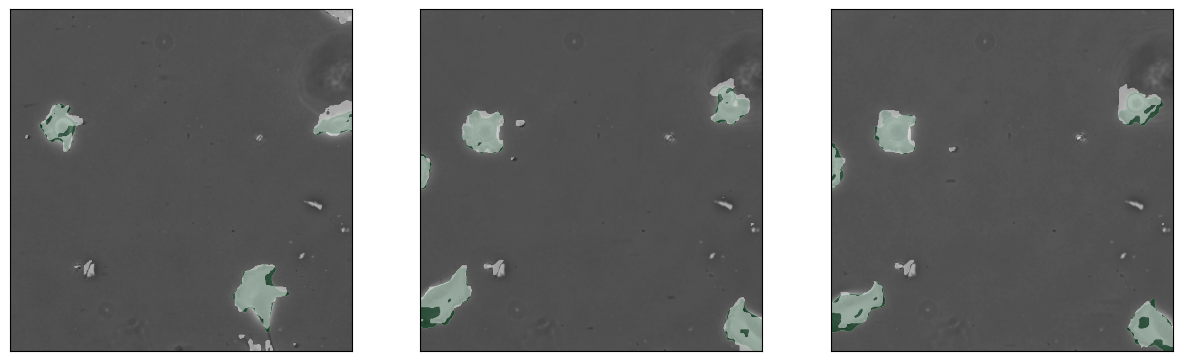

In [21]:
aux = preproc_unet_val(x_val[0:3,:,:,:])
pred = red_unet3(aux[:,:,:,0])

plt.figure(figsize=(15,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  showMaskedImage(aux[i,:,:,0], aux[i,:,:,1], pred.numpy()[i][...,0] > 0.5, maskAlpha=0.5)

plt.show()

In [22]:
model_unet3.evaluate(x_val, batch_size=8)

15/15 [==============================] - 3s 192ms/step - loss: 0.2123 - dice: 0.7877


[0.212308868765831, 0.7876911163330078]

Con el mirror padding tuvo un comportamiento peor que sin este. No se descarta la posibilidad de que haya un error al calcular el padding